In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import foodcosts.core as core
import datetime

# the parameters to set

In [2]:
core.get_shop_names()

['La Hulpe',
 'Fort Jaco',
 'Woluwe',
 'Tongres',
 'Wemmel',
 'CHATELAIN',
 'OVERIJSE',
 'LATEM']

In [31]:
shops = [
    shop for shop in core.get_shop_names() 
#     if not shop == 'Tongres'
]

In [32]:
shops

['La Hulpe',
 'Fort Jaco',
 'Woluwe',
 'Tongres',
 'Wemmel',
 'CHATELAIN',
 'OVERIJSE',
 'LATEM']

In [33]:
start_date = '01-01-2022'
end_date = '02-20-2023'
shop = 'LATEM'
granularity_options = {
    'W' : 'W-MON',
    'D' : 'D',
    'M' : 'M'
}
granularity = granularity_options['M']
transformation = 'TOTAL' # 'PERCENT_OF_REVENUE'
compare_with = 'OVERIJSE' # Or 'ALL'
supplier = 'ALL'
products = 'ALL'

# constants

In [34]:
column_names = [
                   'shop', 
                   'date_and_time',
                   'supplier_name',
                   'po_id',
                   'po_name',
                   'po_line_id', 
                   'po_line_name', 
                   'qty',
                   'price_excl_vat',
                   'total_excl_vat',
                   'total_incl_vat'
                  ]

# The functions

In [35]:
def create_supplier_po_lines_df(start_date,end_date):
    query = """
SELECT
    v_shop.name as shop_name,
    vpo.order_date as date,
    v_supplier.name as supplier_name,
    po.id po_id,
    po.name po_name,
    vpol.id as pol_id,
    pol.name as pol_name,
    vpol.qty as qty,
    pol.price_unit as price_excl_vat,
    pol.price_subtotal as total_excl_vat,
    pol.price_total as total_incl_vat
FROM v_purchase_order_line as vpol
    LEFT JOIN purchase_order_line as pol on vpol.id = pol.id
    LEFT JOIN v_purchase_order as vpo on vpo.id = vpol.purchase_order_id
    LEFT JOIN purchase_order as po on vpo.id = po.id
    LEFT JOIN v_supplier on v_supplier.id = vpo.supplier_id
    LEFT JOIN v_shop on v_shop.id = vpo.shop_id
WHERE v_shop.name <> '' and vpo.order_date between '{}' and '{}';
    """.format(start_date, end_date)
    
    return pd.DataFrame(
        core.make_sql_query(query),
        columns = column_names
    )
    
    
    
#     if shop != '':
#         query += "AND v_shop.name = ('{}')".format(shop)
    
#     query += "GROUP BY v_shop.name, to_char(v_purchase_order.order_date, 'YYYY-MM-DD')"                                                
                          

    

In [36]:
suppliers_df = create_supplier_po_lines_df(start_date, end_date)


In [37]:
suppliers_df

,shop,date_and_time,supplier_name,po_id,po_name,po_line_id,po_line_name,qty,price_excl_vat,total_excl_vat,total_incl_vat
0,ATELIER,2022-07-28 10:43:30,AMEEL CANDY WORLD,31572,PO96545,380893,[9.202] GRAND CUBERDON ROUGE FRAMBOISE 18-20G,15.000,17.05,255.75,271.10
1,ATELIER,2023-01-06 10:24:16,AMEEL CANDY WORLD,41988,PO106961,501497,[9.202] GRAND CUBERDON ROUGE FRAMBOISE 18-20G,30.000,23.10,693.00,734.58
2,ATELIER,2022-06-07 15:23:32,AMEEL CANDY WORLD,28364,PO93337,344368,[9.202] GRAND CUBERDON ROUGE FRAMBOISE 18-20G,5.000,17.05,85.25,90.37
3,ATELIER,2022-04-08 07:58:19,AMEEL CANDY WORLD,24620,PO89593,298332,[9.202] GRAND CUBERDON ROUGE FRAMBOISE 18-20G,20.000,17.05,341.00,361.46
4,ATELIER,2022-01-20 14:34:24,AMEEL CANDY WORLD,20076,PO85049,249919,[9.202] GRAND CUBERDON ROUGE FRAMBOISE 18-20G,15.000,17.05,255.75,271.10
...,...,...,...,...,...,...,...,...,...,...,...
90557,ATELIER,2022-11-12 14:51:22,None,38572,PO103545,461993,[POMME 70G CUITE S/V] POMME 70G CUITE S/V,120.000,4.78,573.60,608.02
90558,ATELIER,2022-11-02 21:20:19,None,37960,PO102933,454423,[CHICON 90G CUIT S/V] CHICON 90G CUIT S/V,100.000,5.46,546.00,578.76
90559,ATELIER,2022-11-09 14:02:17,None,38394,PO103367,459685,[POMME 70G CUITE S/V] POMME 70G CUITE S/V,120.000,4.78,573.60,608.02
90560,ATELIER,2022-11-09 14:02:17,None,38394,PO103367,459684,[CHICON 90G CUIT S/V] CHICON 90G CUIT S/V,150.000,5.46,819.00,868.14


In [38]:
grouped_df = suppliers_df.groupby([
               pd.Grouper(key='date_and_time', 
               freq=granularity), 
    "shop"]
)["total_excl_vat"].sum().reset_index()

In [39]:
def get_atelier_food_costs_period(start_date, end_date):
    query = """
select 
    shop.name as shop,
    stats.day::timestamp as date_and_time,
    'atelier' as supplier_name,
    -1 as po_id,
    'PO/Atelier' as po_name,
    -1 as po_line_id,
    'PO/Atelier/1' as po_line_name,
    1 as qty,
    stats.discounted_atelier_value_sent_htva as price_excl_vat,
    stats.discounted_atelier_value_sent_htva as total_excl_vat,
    stats.discounted_atelier_value_sent as total_incl_vat
from v_shop_sales_statistics as stats 
left join v_shop as shop on shop.id = stats.shop_id
left join pos_order_stat_day on pos_order_stat_day.day = stats.day and (pos_order_stat_day.interval <> 'month')
where stats.day between '{}' and '{}' and discounted_atelier_value_sent_htva < 10000
    """.format(start_date, end_date)
                              
    return pd.DataFrame(
        core.make_sql_query(query),
        columns = column_names
    )

In [40]:
atelier_df = get_atelier_food_costs_period(start_date, end_date)

In [41]:
suppliers_and_atelier_df = pd.concat([atelier_df,suppliers_df])
foodcost_df = suppliers_and_atelier_df

In [42]:
total_foodcost_df = foodcost_df[
        foodcost_df["shop"].isin(shops)
].groupby(pd.Grouper(key='date_and_time',freq=granularity))['total_excl_vat'].sum().reset_index()

In [43]:
na_lines = suppliers_and_atelier_df.loc[suppliers_and_atelier_df['supplier_name'].isna()]

In [44]:
na_lines.groupby('shop')["total_excl_vat"].sum()

shop
ATELIER    11366.69
Name: total_excl_vat, dtype: object

## get_revenues_df

In [45]:
def get_revenues_df(start_date, end_date):
    query = """

  SELECT 
    v_shop.name, 
    day::timestamp,
    total as total_sales
  FROM 
    v_shop_sales_statistics
  LEFT JOIN 
    v_shop on v_shop.id = v_shop_sales_statistics.shop_id
  WHERE 
    day between '{}' and '{}';
    """.format(start_date, end_date)
    res = core.make_sql_query(query)
    return pd.DataFrame(res, columns = ['shop','date_and_time','total_sales'])

In [46]:
revenues_df = get_revenues_df(start_date, end_date)

In [47]:
totals_revenues_df = revenues_df[
    revenues_df["shop"].isin(shops)
].groupby([pd.Grouper(key='date_and_time', freq=granularity)])["total_sales"].sum().reset_index()

In [48]:
total_percent_df = pd.merge(total_foodcost_df, totals_revenues_df, on=['date_and_time'])
total_percent_df['foodcost / revenue'] = (total_percent_df['total_excl_vat'] / total_percent_df['total_sales'])*100
total_percent_df.index = total_percent_df["date_and_time"]

In [49]:
total_percent_df

,date_and_time,total_excl_vat,total_sales,foodcost / revenue
date_and_time,,,,
2022-01-31,2022-01-31,496705.6400000000000015,1477263.19,33.62336808784899053779983511
2022-02-28,2022-02-28,444370.78,1433786.03,30.99282394319325318018337785
2022-03-31,2022-03-31,427877.75,1433837.49,29.84143970178935689566883901
2022-04-30,2022-04-30,430543.75,1421784.41,30.28192931163171215247746316
2022-05-31,2022-05-31,450926.42,1493148.54,30.19970270338944308916512754
2022-06-30,2022-06-30,408343.79,1455113.24,28.06268122472722466603355214
2022-07-31,2022-07-31,391725.95,1325289.94,29.55775473554111487483259701
2022-08-31,2022-08-31,387455.74,1328233.86,29.17074708515562161621147047
2022-09-30,2022-09-30,429385.87,1332096.02,32.23385278187378714636501954


In [50]:
revenues_df.shop.unique()

array(['Woluwe', 'CHATELAIN', 'La Hulpe', 'Fort Jaco', 'Tongres',
       'Wemmel', None, 'OVERIJSE', 'LATEM', 'PAVLOVA BAR ANVERS'],
      dtype=object)

In [51]:
revenues_df.date_and_time[0]

Timestamp('2023-02-08 00:00:00')

# Plots

In [52]:
def plot_revenues(revenues_df, shop, compare_with, granularity):
    shops = [shop, compare_with]
    grouped_revenues_df = revenues_df.groupby([pd.Grouper(key='date_and_time', freq=granularity), "shop"])["total_sales"].sum().reset_index()    
    filtered_revenues_df = grouped_revenues_df[grouped_revenues_df["shop"].isin(shops)]    
    
    # pivot the data to have the shops as columns and the dates as index
    pivoted_df = filtered_revenues_df.pivot(index="date_and_time", 
                                  columns="shop", 
                                  values='total_sales')    
    # plot the data for the 2 shops
    for s in shops:
        plt.plot(pivoted_df.index, pivoted_df[s], label=s)

    ylabel = "Total sales"
    title = "Total sales"
                                                                   
    plt.xlabel("Date")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()


In [53]:
revenues_df
# plot_revenues(revenues_df, 'Fort Jaco', 'Woluwe', granularity)

,shop,date_and_time,total_sales
0,Woluwe,2023-02-08,3590.13
1,CHATELAIN,2022-02-05,4084.49
2,La Hulpe,2023-02-08,2106.95
3,Fort Jaco,2023-02-08,2750.55
4,Tongres,2023-02-08,164.90
...,...,...,...
6954,None,2023-02-07,485.87
6955,None,2023-02-07,605.47
6956,None,2023-02-07,230.06
6957,None,2023-02-07,91.06


In [54]:
total_percent_df

,date_and_time,total_excl_vat,total_sales,foodcost / revenue
date_and_time,,,,
2022-01-31,2022-01-31,496705.6400000000000015,1477263.19,33.62336808784899053779983511
2022-02-28,2022-02-28,444370.78,1433786.03,30.99282394319325318018337785
2022-03-31,2022-03-31,427877.75,1433837.49,29.84143970178935689566883901
2022-04-30,2022-04-30,430543.75,1421784.41,30.28192931163171215247746316
2022-05-31,2022-05-31,450926.42,1493148.54,30.19970270338944308916512754
2022-06-30,2022-06-30,408343.79,1455113.24,28.06268122472722466603355214
2022-07-31,2022-07-31,391725.95,1325289.94,29.55775473554111487483259701
2022-08-31,2022-08-31,387455.74,1328233.86,29.17074708515562161621147047
2022-09-30,2022-09-30,429385.87,1332096.02,32.23385278187378714636501954


In [55]:
def plot_food_costs(foodcost_df, revenues_df=None, shop='', compare_with='', granularity='M', plt=plt):
    # read in the data frame and group by day and shop
    grouped_foodcost_df = foodcost_df.groupby([pd.Grouper(key='date_and_time', freq=granularity), "shop"])["total_excl_vat"].sum().reset_index()
    
    # filter the data for the 2 shops you want to plot
    shops = [shop, compare_with]
    filtered_foodcost_df = grouped_foodcost_df[grouped_foodcost_df["shop"].isin(shops)]
    
    if revenues_df is not None:
        grouped_revenues_df = revenues_df.groupby([pd.Grouper(key='date_and_time', freq=granularity), "shop"])["total_sales"].sum().reset_index()    
        filtered_revenues_df = grouped_revenues_df[grouped_revenues_df["shop"].isin(shops)]
        percent_df = pd.merge(filtered_foodcost_df, filtered_revenues_df, on=['date_and_time','shop'])
        percent_df['foodcost / revenue'] = (percent_df['total_excl_vat'] / percent_df['total_sales'])*100
#         if hasattr(plt,'set_ylim'):
#             plt.set_ylim([0, 100])
#         else:
#             plt.ylim([0, 100])
    
    df_used_to_plot = percent_df if revenues_df is not None else filtered_foodcost_df
    column_to_sum_over = "foodcost / revenue" if revenues_df is not None else "total_excl_vat"
    
    # pivot the data to have the shops as columns and the dates as index
    pivoted_df = df_used_to_plot.pivot(index="date_and_time", 
                                  columns="shop", 
                                  values=column_to_sum_over)
    
    
    if compare_with == 'ALL':
        plt.plot(total_percent_df.index, total_percent_df["foodcost / revenue"], label = 'ALL')
        plt.plot(pivoted_df.index, pivoted_df[shop], label=shop)
    else:
        for s in shops:
            plt.plot(pivoted_df.index, pivoted_df[s], label=s)
        
        
    # plot the data for the 2 shops

    ylabel = "Total Excl VAT" if revenues_df is None else "Foodcost / revenue (%)"
    title = "Total Excl VAT" if revenues_df is None else "Foodcost / revenue (%)"
                                           

    if hasattr(plt,'xlabel'):        
        plt.xlabel("Date")
    else:
        plt.set_xlabel("Date")

    if hasattr(plt,'xlabel'):        
        plt.ylabel(ylabel)
    else:
        plt.set_ylabel(ylabel)
    
#     if hasattr(plt,'title'):        
#         plt.title(title)

    if hasattr(plt,'legend'):        
        plt.legend()
    else:
        plt.set_legend()

    if hasattr(plt,'show'):
        plt.show()


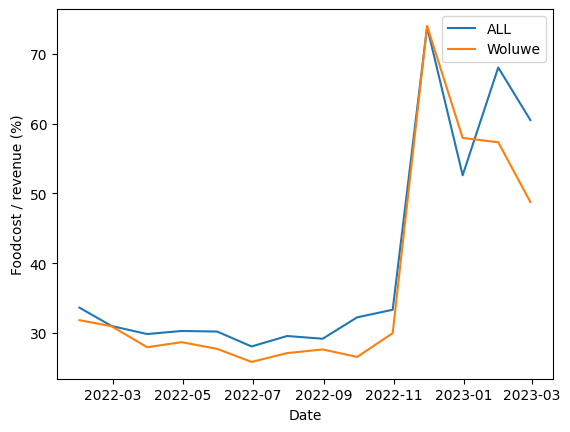

In [56]:
plot_food_costs(foodcost_df, revenues_df, 'Woluwe', 'ALL', granularity)

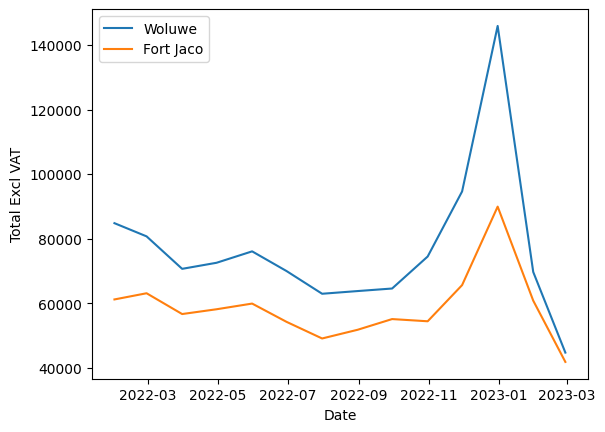

In [57]:
plot_food_costs(foodcost_df, shop='Woluwe', compare_with='Fort Jaco', granularity=granularity)

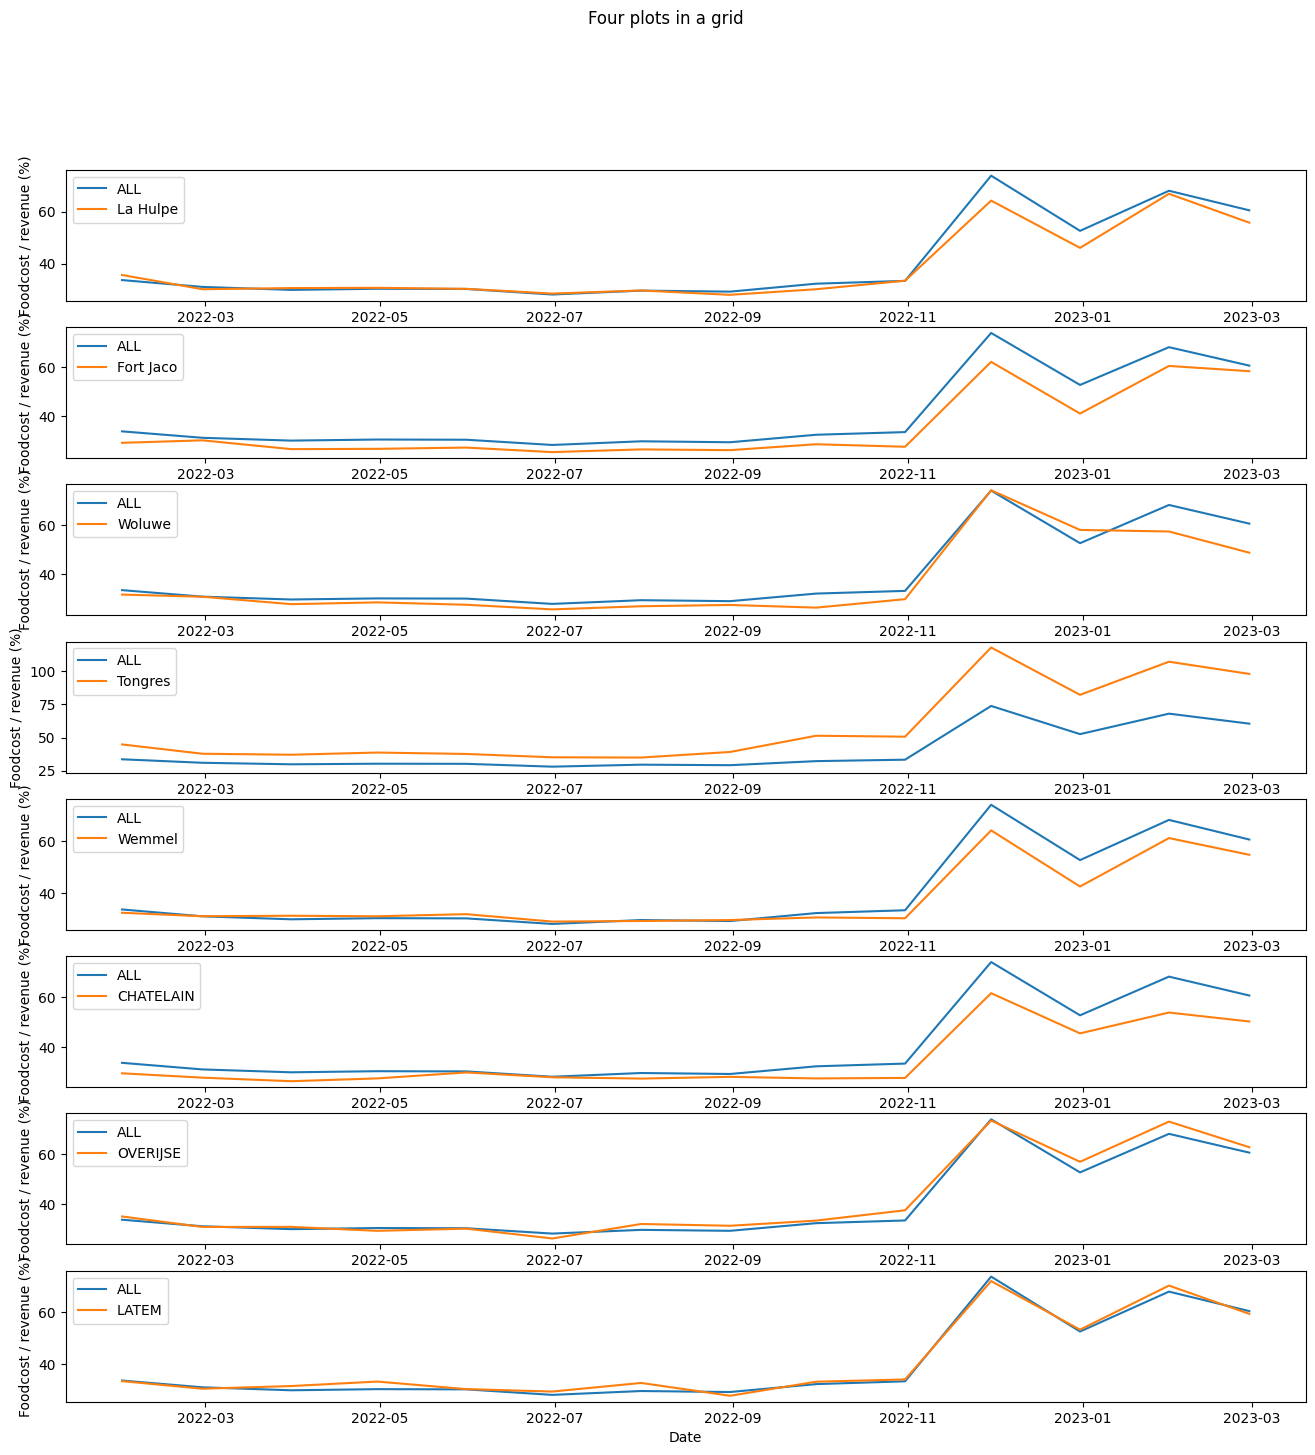

In [59]:
import matplotlib.pyplot as plt
import numpy as np

# generate some sample data
# x = np.linspace(0, 10, 100)
# y1 = np.sin(x)
# y2 = np.cos(x)
# y3 = np.tan(x)
# y4 = np.exp(x)

shops_to_plot = [
        'La Hulpe',
        'Fort Jaco',
        'Woluwe',
        'Tongres',        
        'Wemmel',
        'CHATELAIN',        
        'OVERIJSE',
        'LATEM'        
]

# create a 2x2 grid of plots
fig, axs = plt.subplots(nrows=len(shops_to_plot), ncols=1, figsize=(16, 16))

for ri, shop_name in enumerate(shops_to_plot):
#     for ci, shop_name in enumerate(row): 
    plot_food_costs(
        foodcost_df, 
        revenues_df, 
        shop=shop_name, 
        compare_with='ALL', 
        granularity=granularity, 
        plt=axs[ri]
    )

fig.suptitle('Four plots in a grid')

# display the figure
plt.show()
